# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [3]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [6]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# Accuracy, Precision, Recall for Full Model
acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full)
rec_full = recall_score(yf_test, ypred_full)

# Accuracy, Precision, Recall for Reduced Model
acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced)
rec_reduced = recall_score(yr_test, ypred_reduced)

print("Full Model:")
print(f"  Accuracy:  {acc_full:.3f}")
print(f"  Precision: {prec_full:.3f}")
print(f"  Recall:    {rec_full:.3f}")

print("\nReduced Model:")
print(f"  Accuracy:  {acc_reduced:.3f}")
print(f"  Precision: {prec_reduced:.3f}")
print(f"  Recall:    {rec_reduced:.3f}")


Full Model:
  Accuracy:  0.723
  Precision: 0.733
  Recall:    0.678

Reduced Model:
  Accuracy:  0.717
  Precision: 0.736
  Recall:    0.651


## 4) Plot ROC and Precision–Recall Curves

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


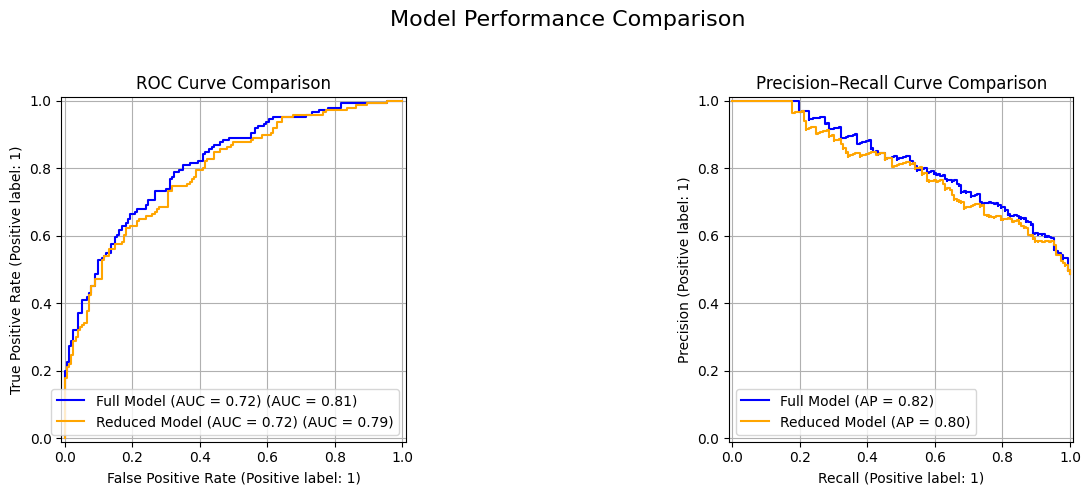

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
RocCurveDisplay.from_predictions(
    yf_test, yprob_full, ax=axes[0], name='Full Model (AUC = {:.2f})'.format(clf_full.score(Xf_test, yf_test)), color='blue'
)
RocCurveDisplay.from_predictions(
    yr_test, yprob_reduced, ax=axes[0], name='Reduced Model (AUC = {:.2f})'.format(clf_reduced.score(Xr_test, yr_test)), color='orange'
)
axes[0].set_title("ROC Curve Comparison")
axes[0].legend(loc='lower right')
axes[0].grid(True)

# Precision–Recall Curve
PrecisionRecallDisplay.from_predictions(
    yf_test, yprob_full, ax=axes[1], name='Full Model', color='blue'
)
PrecisionRecallDisplay.from_predictions(
    yr_test, yprob_reduced, ax=axes[1], name='Reduced Model', color='orange'
)
axes[1].set_title("Precision–Recall Curve Comparison")
axes[1].legend(loc='lower left')
axes[1].grid(True)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

## 1) ROC-AUC & PR-AUC

The reduced model has a higher ROC-AUC while the full model has a higher PR-AUC. This means that reduced model is better at ranking predictions overall, but the full model is better at precision across all levels. The reduced model is only using CAPE, so the inclusion of PWAT in full model improves the ability to identify true events with fewer false positives... meaning it helps improve precision and recall. 

## 2) Comparing Accuracy, Precision and Recall for both models. 

Overall, the Full Model offers a better balance between precision and recall, and its inclusion of PWAT and Shear makes it more robust for detecting events in real-world applications.

**Maximum Event Detection (Recall)**: I would choose the Full Model. It captures more true events.

**Minimize False Alarms (Precision)**: The Reduced Model performs slightly better.
